## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

This code has been developed by `Mohit Kumar` and `Amit Kumar` as part of project: `Ticket Classification Assignment`

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install  plotly

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!gdown https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
100% 83.4M/83.4M [00:00<00:00, 86.3MB/s]


In [5]:
# Opening JSON file 
f = open("/content/complaints-2021-05-14_08_16.json","r") # Write the path to your data file and load it 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.

df.shape

(78313, 22)

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Rename columns in readable format
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'tags', 
                    '_source.zip_code': 'zip_code', '_source.complaint_id': 'complaint_id',
                    '_source.complaint_id': 'complaint_id', '_source.issue': 'issue',
                    '_source.date_received': 'date_received', '_source.state': 'state',
                    '_source.consumer_disputed': 'consumer_disputed', '_source.product': 'product',
                    '_source.company_response': 'company_response', '_source.company': 'company',
                    '_source.submitted_via': 'submitted_via', '_source.date_sent_to_company': 'date_sent_to_company',
                    '_source.company_public_response': 'company_public_response', '_source.sub_product': 'sub_product',
                    '_source.timely': 'timely', '_source.complaint_what_happened': 'complaint_what_happened',
                    '_source.sub_issue': 'sub_issue', '_source.consumer_consent_provided': 'consumer_consent_provided'}, inplace = True)

In [10]:
#Let's check if we have blank complaints
df[df['complaint_what_happened']==""].shape

(57241, 22)

In [11]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']== ''] = np.nan 

In [12]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]
    

In [13]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [14]:
#Download wordnet and stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text


In [16]:
#Write your function to Lemmatize the texts

def lemmatizer(text):      
    text = clean_text(text)  
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [17]:
#Create a dataframe('df_clean') that will have only the clean complaints and the lemmatized complaints 
tqdm.pandas()
df_clean = pd.DataFrame()
df_clean['clean_complaints'] = df['complaint_what_happened'].progress_apply(lambda x: clean_text(x))
df_clean['lemmatized_complaints'] = df_clean['clean_complaints'].progress_apply(lambda x: lemmatizer(x))

100%|██████████| 21072/21072 [10:38<00:00, 33.01it/s]


In [18]:
df_clean.head(5)

,clean_complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [19]:
#Write your function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['POS_clean_complaint'] = df_clean['clean_complaints'].progress_apply(lambda x: pos_tag(x))

100%|██████████| 21072/21072 [13:28<00:00, 26.05it/s]


In [21]:
df_clean.columns

Index(['clean_complaints', 'lemmatized_complaints', 'POS_clean_complaint'], dtype='object')

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

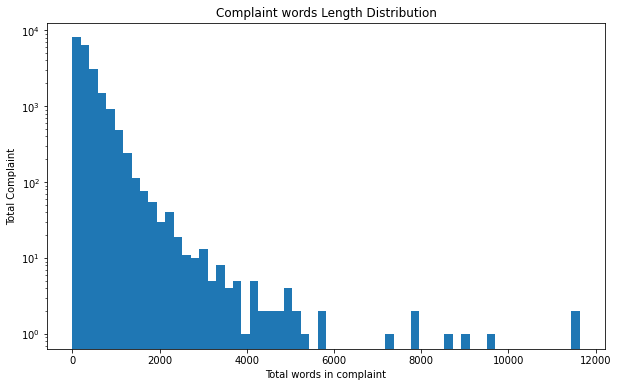

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
corpus_text_length = [len(d) for d in df_clean["POS_clean_complaint"]]
plt.figure(figsize=(10,6))
plt.title("Complaint words Length Distribution")
plt.hist(corpus_text_length, bins = 60,log=True)
plt.xlabel("Total words in complaint")
plt.ylabel("Total Complaint")

plt.show()



1.   Majority of Complaint has smaller number of complaint words length.
2.   Very few complaints has number of words greater than 10K words.



#### Find the top 40 words by frequency among all the articles after processing the text.

In [24]:
df_clean.head(5)

,clean_complaints,lemmatized_complaints,POS_clean_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...


In [25]:
from wordcloud import WordCloud, STOPWORDS

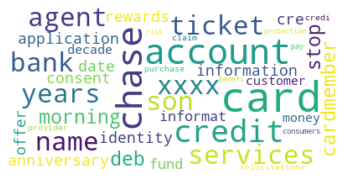

In [26]:

#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Remove the common stop words while plotting worldcloud
wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white", stopwords=stopwords.words("english")).generate(str(df_clean["POS_clean_complaint"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['clean_complaints'] = df_clean['POS_clean_complaint'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
# Function to build n-grams
def get_top_n_gram(text_corpus,n_grams = 1,freq=30):
    vectorizer = CountVectorizer(ngram_range=(n_grams, n_grams), stop_words='english')
    bow_model = vectorizer.fit_transform(text_corpus)
    sum_words = bow_model.sum(axis=0) 
    word_gram = pd.DataFrame(sum_words, columns = vectorizer.get_feature_names())
    #print(word_gram.head(1))
    word_gram = word_gram.sort_values(by=word_gram.index[0],axis=1,ascending=False)
    #print(word_gram.head(1))
    top_words = []
    i=0
    for col in word_gram.columns:
      if(i<=freq):
        top_words.append(col)
        i=i+1
      else:
        break
   # print(top_words[:10]) 
    return top_words

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram = get_top_n_gram(df_clean['clean_complaints'],1,30)

In [30]:
#Print the top 10 words in the unigram frequency
unigram[:10]

['account',
 'chase',
 'credit',
 'card',
 'bank',
 'payment',
 'xxxx',
 'money',
 'time',
 'information']

In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean). 
bigram = get_top_n_gram(df_clean['clean_complaints'],2,30)

In [32]:
#Print the top 10 words in the bigram frequency
bigram[0:10]

['credit card',
 'credit report',
 'customer service',
 'chase credit',
 'account account',
 'chase account',
 'checking account',
 'account chase',
 'bank account',
 'credit cards']

In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned dataframe(df_clean). 
trigram = get_top_n_gram(df_clean['clean_complaints'],3,30)


In [34]:
#Print the top 10 words in the trigram frequency
trigram[0:10]

['chase credit card',
 'credit card account',
 'credit card company',
 'credit card credit',
 'credit card chase',
 'card credit card',
 'account credit card',
 'credit report credit',
 'inquiry credit report',
 'credit reporting agencies']

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [35]:
df_clean['clean_complaints'] = df_clean['clean_complaints'].str.replace('xxxx','')

In [36]:
df_clean.head()

,clean_complaints,lemmatized_complaints,POS_clean_complaint
1,morning name stop bank cardmember services deb...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...
2,card agent anniversary date agent information ...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...
10,card application identity consent services cre...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...
11,ticket offer ticket rewards card information ...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...
14,son chase account fund bank account money son ...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer

In [38]:
#Write your code here to initialise the TfidfVectorizer 

vectorizer = TfidfVectorizer(stop_words='english',max_df = 0.95,min_df = 2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_model = vectorizer.fit_transform(df_clean["clean_complaints"])

In [40]:
#Lets print tifidf score for 10 samples.
pd.DataFrame(tfidf_model.toarray(), columns=vectorizer.get_feature_names()).head(10)

,aaaratings,abandonment,abatement,abide,abiding,abilities,ability,abs,absence,absolute,absurdity,abundance,abuse,abuser,abuses,ac,acc,acccount,acccounts,acceleration,accent,accents,accept,acceptance,access,accessibility,accessories,accessory,accident,accidents,accommodation,accommodations,accomplice,accomplices,accont,accord,accordance,according,accords,accou,...,wound,wrap,wreck,wrist,wristbands,writ,write,writeoff,writer,writers,writing,writings,wrong,wrongdoing,wrongdoings,wrongs,wthe,wwwchasecom,wwwconsumerfinancegov,xx,yard,yea,year,yearold,years,yeas,yesterday,yield,yields,yoga,youth,yr,yrs,ys,ytd,zeros,zip,zombie,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060044,0.0,0.051312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
# we'll start with 8 random topics and will categorise them further into 5
num_topics = 8 

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 45) #write your code here

In [43]:
nmf_model.fit(tfidf_model)


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=8, random_state=45, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [44]:
doc_term_matrix = nmf_model.transform(tfidf_model)
topic_term_matrix= nmf_model.components_

In [45]:
#Print the Top15 words for each of the topics

words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = topic_term_matrix[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,checking,balance,accounts,reason,branch,funds,savings,business,number,deposit,information,fees,letter
Topic 2,credit,report,inquiry,inquiries,accounts,score,debt,information,cards,bureaus,reports,identity,reporting,company,letter
Topic 3,loan,mortgage,modification,home,chase,property,payments,years,rate,foreclosure,house,sale,time,documents,letter
Topic 4,card,credit,chase,cards,fee,balance,points,offer,debit,customer,months,purchases,limit,application,freedom
Topic 5,payment,payments,balance,month,fees,statement,fee,date,time,days,auto,credit,error,day,chase
Topic 6,check,funds,checks,deposit,bank,days,hold,branch,chase,business,day,refund,teller,customer,cashier
Topic 7,money,bank,funds,transaction,claim,atm,branch,transactions,accounts,transfer,person,number,debit,day,fraud
Topic 8,charges,charge,dispute,chase,merchant,fraud,letter,claim,information,company,transaction,phone,email,refund,number


In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

len(doc_term_matrix.argmax(axis=1))

21072

In [47]:
#Assign the best topic to each of the complaints in Topic Column
#we'll take the maximum topic score for each row to assign the best topic.
df_clean['Topic'] = doc_term_matrix.argmax(axis=1)

In [48]:
df_clean["Topic"].unique()

array([6, 3, 1, 5, 0, 4, 7, 2])

In [49]:
df_clean.shape

(21072, 4)

In [50]:
#Print the first 5 Complaint for each of the Topics
df_top=df_clean.groupby('Topic').head(5)
df_top.sort_values('Topic')

,clean_complaints,lemmatized_complaints,POS_clean_complaint,Topic
69,felony security number name checking account a...,someone called stating felony committed social...,felony security number name checking account a...,0
27,account code terms account deposit bonus days...,opened account chase bank xxxx used code xxxx ...,account code xxxxxxxx terms account deposit bo...,0
17,notice account debit card branch customer serv...,notice jp morgan chase restricted account debi...,notice account debit card branch customer serv...,0
35,saving account bonus bonus auto transfers savi...,opened saving account bonus supposed received ...,saving account bonus bonus auto transfers savi...,0
24,account,mishandling account chase auto xxxx,account,0
83,credit bureau date name company chase auto,unknown inquire reported credit bureau xxxx xx...,credit bureau date xxxxname company chase auto,1
11,ticket offer ticket rewards card information ...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,1
15,inquiry,please remove inquiry,inquiry,1
26,times attempt inquiry creditor inquiry report ...,reached xxxx several time attempt fraudulent i...,times attempt inquiry creditor inquiry report ...,1
23,chase credit card data credit report company i...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
#Create the dictionary of Topic names and Topics
# Let's reduce number of categories from 8 to 5 by merging multiple topics which seems similar.
topic_map = {  0:"Bank Account services",
               5:"Bank Account services",
               3:"Credit card or prepaid card",
               7:"Theft/Dispute Reporting",
               2:"Mortgage/Loan",
               1:"Others",
               4:"Others",
               6:"Others"}
               
#Replace Topics with Topic Description
df_clean['Topic'] = df_clean['Topic'].map(topic_map)

In [52]:
df_clean.head(5)

,clean_complaints,lemmatized_complaints,POS_clean_complaint,Topic
1,morning name stop bank cardmember services deb...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,Others
2,card agent anniversary date agent information ...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,Credit card or prepaid card
10,card application identity consent services cre...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,Credit card or prepaid card
11,ticket offer ticket rewards card information ...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,Others
14,son chase account fund bank account money son ...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,Bank Account services


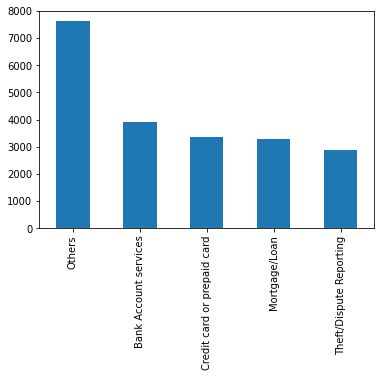

In [53]:
df_clean.Topic.value_counts().plot.bar()

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
#Create the dictionary again of Topic names and Topics

topic_map = {"Bank Account services":0,
               "Mortgage/Loan":1, 
               "Credit card or prepaid card":2,
               "Theft/Dispute Reporting":3,
               "Others":4
               }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_map)

In [130]:
df_clean.head()

,clean_complaints,lemmatized_complaints,POS_clean_complaint,Topic
1,morning name stop bank cardmember services deb...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,4
2,card agent anniversary date agent information ...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,2
10,card application identity consent services cre...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,2
11,ticket offer ticket rewards card information ...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,4
14,son chase account fund bank account money son ...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,0


In [131]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["clean_complaints","Topic"]]

In [132]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [166]:

#Write your code to get the Vector count
vectorizer = CountVectorizer(stop_words='english',max_df = 0.95,min_df = 2)
X_train_data = vectorizer.fit_transform(training_data['clean_complaints'])

#Write your code here to transform the word vector to tf-idf

#tfidf_vect = TfidfVectorizer(stop_words='english',max_df = 0.95,min_df = 2)
#X_train_tfidf = tfidf_vect.fit_transform(training_data['clean_complaints'])

tfidf_model = TfidfTransformer(use_idf=True)
X_train_tfidf = tfidf_model.fit_transform(X_train_data)



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [167]:
# Split the dataset in train and test
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data["Topic"], test_size=0.2, random_state=45)
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (16857, 7355)
Shape of y_train:  (16857,)
Shape of X_test:  (4215, 7355)
Shape of y_test:  (4215,)


## Logistic Regression 
We'll building multi-nominal logisitic regression.

In [168]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
#Set higher max_iter for solution to converge, use l2 regularization for avoiding overfitting.
log_reg = LogisticRegression(multi_class = "multinomial",solver="lbfgs", penalty='l2',C=0.5,max_iter=300)
log_reg.fit(X_train,y_train)



LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
y_pred = log_reg.predict(X_test)
# Let's Evaluate the Model with F1_Score

f1_score = round(f1_score(y_test,y_pred, average='weighted'), 2)
print("F1 Score for Multinominal Logistic Regression is {}".format(f1_score))

F1 Score for Multinominal Logistic Regression is 0.9


Logistic Regression has impressive F1_score of 0.90

## Decision Tree

In [170]:
from sklearn.tree import DecisionTreeClassifier


In [171]:
dt_model = DecisionTreeClassifier(max_depth=20,min_samples_split=5)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [172]:
from sklearn.metrics import f1_score
y_pred = dt_model.predict(X_test)
# Let's Evaluate the Model with F1_Score

f1_score = round(f1_score(y_test,y_pred, average='weighted'), 2)
print("F1 Score for Multi-class Decision Tree is {}".format(f1_score))

F1 Score for Multi-class Decision Tree is 0.82


# Random Forest
We'll be using Random Forest classifer for multi-class classification.
In order to find the best hyperparameter and RF model, GridSearchCrossValidation will be used.

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [174]:
rf = RandomForestClassifier(random_state=45, n_jobs=-1)


In [175]:
params = {
    'max_depth': [10,20,30,50,100],
    'min_samples_leaf': [10,20,50,100],
    'n_estimators': [100, 200, 300, 500]
}

In [176]:
#Initialise GridSearchCV with scoring opetion as F1_Macro for multi-class
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1_macro") 

In [177]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 22.9min finished


CPU times: user 35.9 s, sys: 960 ms, total: 36.9 s
Wall time: 23min 7s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=45,
                                    

In [178]:
grid_search.best_score_

0.7659827582621033

In [179]:
# get the Best Random Forest
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [180]:
from sklearn.metrics import f1_score
y_pred = rf_best.predict(X_test)
# Let's Evaluate the Model with F1_Score

f1_score = round(f1_score(y_test,y_pred, average='weighted'), 2)
print("F1 Score for Multi-class Random Forest is {}".format(f1_score))

F1 Score for Multi-class Random Forest is 0.78


**Observation: Random Forest has F1 Score of 0.78.**

# Naive Bayes
We'll be using Multinominal Naive Bayes Model

In [181]:
from sklearn.naive_bayes import MultinomialNB

In [182]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [183]:
from sklearn.metrics import f1_score

y_pred = nb_model.predict(X_test)
f1 = round(f1_score(y_test,y_pred, average='weighted'), 3)
print("F1 Score for Multi-Class Naive Bayes Model is {}".format(f1))

F1 Score for Multi-Class Naive Bayes Model is 0.654


**Observation: Among all the 4 Model developed, Multi-Class Logistic Regression Model has best F1 Score = 0.90. We'll selecting this model for our Final Prediction.**

Finally we'll using the LR Model to evaluate custom text.

In [184]:
custom_corpus = ["Credit Card purchase","Loan rejection letter","Fraud transaction happened","refund status on card fraud"
  ,"my cashier check has not been cashed","intra day trading"]
topics = log_reg.predict(vectorizer.transform(custom_corpus))

In [185]:
topic_map = {0: "Bank Account services",
               1: "Mortgage/Loan", 
               2: "Credit card or prepaid card",
               3: "Theft/Dispute Reporting",
               4: "Others"
               }

In [186]:
topic_arr = []
for topic in topics:
    topic_arr.append(topic_map.get(topic))

custom_topic = zip(custom_corpus,topic_arr)
for out in list(custom_topic):
    print(out)

('Credit Card purchase', 'Credit card or prepaid card')
('Loan rejection letter', 'Mortgage/Loan')
('Fraud transaction happened', 'Theft/Dispute Reporting')
('refund status on card fraud', 'Credit card or prepaid card')
('my cashier check has not been cashed', 'Bank Account services')
('intra day trading', 'Others')
